In [1]:
import pandas as pd

In [2]:
tripod = pd.read_csv('TRIPOD_screenplays_test.csv')

In [3]:
tripod

,movie_name,tp1,tp2,tp3,tp4,tp5
0,The Back-up Plan,"[9, 10]","[40, 41]",[82],"[106, 107, 111]",[131]
1,The Shining (film),[6],[38],[76],"[177, 178]","[223, 225, 227, 228, 229]"
2,Juno (film),[3],"[31, 32]","[39, 40, 41]","[86, 87, 89]",[107]
3,Soldier (1998 American film),[35],[51],[109],[210],[223]
4,Panic Room,"[17, 18, 20]","[56, 58]",[135],[148],"[159, 160]"
5,Arbitrage (film),"[35, 36, 37]","[57, 62]","[67, 87, 88]",[105],[109]
6,The Breakfast Club,[5],[20],[31],[31],"[34, 39]"
7,Slumdog Millionaire,[32],[108],[139],"[150, 157]","[188, 191]"
8,Total Recall (1990 film),[16],"[51, 53, 55]",[72],[112],"[145, 146, 147, 148, 149, 150, 151, 152, 153, ..."
9,Unforgiven,"[6, 7]",[53],"[88, 91]",[95],[98]


In [4]:
import os

In [5]:
import re
from collections import Counter
import numpy as np
import json

In [6]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [7]:
class Movie:
    def __init__(self, name):
        self.name = name
        self.getContents()
        self.seperate_scenes()
        self.characters_per_scene()
        
    def getContents(self):
        with open(self.name,'r') as f:
            movie_contents = f.readlines()
        contents = []
        for content in movie_contents:
            content = content.strip('\n').strip()
            if content:
                contents.append(content)
        i = 1
        while i:
            if not contents[i][0].isupper() and contents[i][0]!='=':
                contents[i-1] += ' ' + contents[i]
                del contents[i]
            else:
                i+=1
            if i>=len(contents):
                i = 0
        self.contents = contents
        _, speaker, _ = self.extract_sentence(self.contents)
        self.speaker = set(speaker)
    
    def extract_sentence(self, contents):
        dialog, speaker, contents = self.seperate_dialog(contents)
        new_contents = []
        for content in contents:
            if '.' in content:
                for con in content.split('.'):
                    if con:
                        new_contents.append(con+'.')
            else:
                new_contents.append(content)
        return dialog, speaker, new_contents
    
    def seperate_dialog(self,contents):
        dialog = []
        speaker = []
        nor_sent = []
        stop_words = ['-',":","CONTINUE","END","NEARBY","OUTSIDE"]
        swit = 0
        for i in range(len(contents)):
            if swit:
                swit = 0
                continue
            text = contents[i]
            if any(word in text for word in stop_words):
                continue
            text = re.sub(r'\([^)]*\)', '', text).strip()
            #text = text.replace('.','')
            if text.isupper() and text.count(' ')<2 and i+1!=len(contents) and '!' not in text:
                speaker.append(re.sub('[^a-zA-Z]','',text).replace(' ',''))
                dialog.append(contents[i+1])
                swit = 1
                continue
            nor_sent.append(contents[i])
        return dialog, speaker, nor_sent
    
    def seperate_scenes(self):
        stop_words = ['====================']
        scenes =[]
        scene = []
        start = 1
        for cont in self.contents:
            if any(word in cont for word in stop_words):
                if start:
                    start = 0
                    scene = []
                    continue
                if scene:
                    scene.append(cont.replace('=','')[:-1])
                    scenes.append(scene)
                scene = []
                continue
            if cont:    
                scene.append(cont)
            
        self.scenes = scenes
        
    def characters_per_scene(self):
        self.scene_dict = {}
        for i, scene in enumerate(self.scenes):
            char_sent = {}
            dialog, speaker, nor_sent = self.extract_sentence(scene)
            for char, dia in zip(speaker, dialog):
                if char not in char_sent.keys():
                    char_sent[char] = [dia]
                else:
                    char_sent[char] += [dia]
            for sent in nor_sent:
                for char in self.speaker:
                    if char.lower()+' ' in sent.lower() or char.lower()+'.' in sent.lower():
                        if char not in char_sent.keys():
                            char_sent[char] = [sent]
                        else:
                            char_sent[char] += [sent]
            self.scene_dict[i+1] = char_sent
    
    def find_maincharacter_name(self):
        num_occur = Counter(self.speaker)
        main_characters_list = num_occur.most_common(5)
        main_characters = []
        for character, count in main_characters_list:
            main_characters.append(character)
        return main_characters
    

In [8]:
tps = {}
for i in range(1,6): 
    tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==moviename]['tp'+str(i)].values]
    tp = list(map(int, tp[0]))
    tps['tp'+str(i)] = tp

NameError: name 'moviename' is not defined

In [9]:
from transformers import AutoTokenizer, AutoModel

In [10]:
from sentence_transformers import SentenceTransformer, util
import torch

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [11]:
model = AutoModel.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-MiniLM-L6-cos-v1")

In [12]:
def make_embedding(sentences):
    vecs = []
    with torch.no_grad():

        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True,  max_length=64)

            hidden_states = model(**inputs, return_dict=True, output_hidden_states=True).hidden_states

            #Averaging the first & last hidden states
            output_hidden_state = (hidden_states[-1] + hidden_states[1]).mean(dim=1)

            vec = output_hidden_state.cpu().numpy()[0]

            vecs.append(vec)
    return vecs

In [13]:
import networkx as nx
import csv

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

2022-10-20 15:32:00.194371: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-20 15:32:02.183919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-20 15:32:02.184403: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/lib64
2022-10-20 15:32:02.184449: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would lik

In [15]:
def read_graph(edgeList,weighted=False, directed=False):
    '''
    Reads the input network in networkx.
    '''
    if weighted:
        G = nx.read_edgelist(edgeList, nodetype=str, delimiter='  ', data=(('type',int),('weight',float),('id',int)), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(edgeList, nodetype=str, delimiter='  ', data=(('type',int),('id',int)), create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1.0

    if not directed:
        G = G.to_undirected()

    # print (G.edges(data = True))
    return G

In [16]:
from gensim.models import Word2Vec

# Text Rank 

In [20]:
!pip install gensim==3.4.0

  Using cached gensim-3.4.0-cp38-cp38-linux_x86_64.whl
  Attempting uninstall: gensim
    Found existing installation: gensim 4.2.0
    Uninstalling gensim-4.2.0:
      Successfully uninstalled gensim-4.2.0


In [21]:
from gensim.summarization.summarizer import summarize

In [22]:
movie_main = {}
for num, name in enumerate(tripod['movie_name']):
    print(name)
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    total_sentence = []
    for value in mov.scene_dict.values():
        for v in value.values():
            for i in v:
                total_sentence.append(i)
    main_act = summarize('\n'.join(list(set(total_sentence))), ratio=0.3)
    main_act = main_act.split('\n')
    movie_main[name] = main_act

The Back-up Plan
The Shining (film)
Juno (film)
Soldier (1998 American film)
Panic Room
Arbitrage (film)
The Breakfast Club
Slumdog Millionaire
Total Recall (1990 film)
Unforgiven
Die Hard
Moon (film)
One Eight Seven
The Crying Game
The Last Temptation of Christ (film)


In [23]:
import json
with open('./text_rank3.json', 'w') as outfile:
    json.dump(movie_main, outfile)

In [25]:
import csv

In [21]:
with open('text_rank.json','r') as outfile:
    a = json.load(outfile)

In [17]:
from gensim.models import Word2Vec


In [18]:
import random

In [19]:
walk_length = 5  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.

metapaths = [
    ["act", "scene", "act"],
#    ["act", "act", "scene", "act", "act"],
    ["act",'char', "act"],
#    ["act", "act", "char", "act", "act"],
#    ['char','act','scene','act','char'],
    ['scene','act','char','act','scene']
]
metapaths2 = [
    ['char','act','scene','act','char']
]

In [375]:
mov_scene = {}

for num, name in enumerate(tripod['movie_name']):
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = emb        
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
    kernel, bias = compute_kernel_bias([total_embedding])

        
    
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding.items()):
            #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
            #if i != len(scene_embedding_reduction.items())-1:
            #    g_list.append([line])
            #id_num +=1 
        sent_num = 1
        for char, embs in contents.items():        
            for emb in embs:
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                emb_act.append([emb,str(scene) + '_act_' + str(sent_num)])
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                    id_num += 1
                    g_list.append([line])

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=2,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )

    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=60,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )

    walks = []
    for w in walks1:
        if len(w)>1:
            walks.append(w)
    for w in walks2:
        if len(w)>1:
            walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=384, window=3, min_count=0, sg=1, workers=4, epochs=0, seed = num)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
    
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    random.shuffle(walks)
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    w2v.save('word2vec_tripod_dim=384/'+ name + 'word2vec.model')
    mov_scene[name] = node_ids
    

Number of random walks: 7642
Number of random walks: 7696
Number of random walks: 5926
Number of random walks: 8658
Number of random walks: 5178
Number of random walks: 7258
Number of random walks: 4432
Number of random walks: 8800
Number of random walks: 9182
Number of random walks: 7410
Number of random walks: 7144
Number of random walks: 5326
Number of random walks: 7098
Number of random walks: 7100
Number of random walks: 7208


In [29]:
p=0
while p<10:
    p+=1
    mov_scene = {}

    for num, name in enumerate(tripod['movie_name']):
        mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
        scene_embedding = {}
        total_embedding = []
        total_sentence = []

        for i, char_dict in mov.scene_dict.items():
            scene = {}
            for char, sent in char_dict.items():
                emb = make_embedding(sent)
                scene[char] = emb        
                total_embedding += emb
                total_sentence +=sent
            scene_embedding[i] = scene
        #kernel, bias = compute_kernel_bias([total_embedding])



        emb_act = []
        g_list = []
        id_num = 1
        node_embedding = {}
        total_act = []
        for i, (scene, contents) in enumerate(scene_embedding.items()):
                #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
                #if i != len(scene_embedding_reduction.items())-1:
                #    g_list.append([line])
                #id_num +=1 
            sent_num = 1
            for char, embs in contents.items():        
                for emb in embs:
                    line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                    total_act.append(str(scene) + '_act_' + str(sent_num))
                    node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                    emb_act.append([emb,str(scene) + '_act_' + str(sent_num)])
                    id_num += 1
                    g_list.append([line])
                    line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                    id_num += 1
                    sent_num += 1
                    g_list.append([line])
            if sent_num!=1:     
                for j in range(1,sent_num):
                    for k in range(j+1,sent_num):
                        line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                        id_num += 1
                        g_list.append([line])



        with open('test.csv', 'w',newline='') as f: 
            write = csv.writer(f)    
            write.writerows(g_list)
        g= read_graph('test.csv')
        attr = {}
        for node in g.nodes():
            if 'scene' in node:
                attr[node]='scene'
            elif 'act' in node:
                attr[node]='act'
            elif 'char' in node:
                attr[node]='char'
        nx.set_node_attributes(g, attr,"label")
        stellar_g = StellarGraph.from_networkx(g)
        stellar_g.info()

           # Create the random walker
        rw = UniformRandomMetaPathWalk(stellar_g)

        walks1 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=2,  # number of random walks per root node
            metapaths=metapaths,  # the metapaths
        )

        walks2 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=60,  # number of random walks per root node
            metapaths=metapaths2,  # the metapaths
        )

        walks = []
        for w in walks1:
            if len(w)>1:
                walks.append(w)
        for w in walks2:
            if len(w)>1:
                walks.append(w)

        #print("Number of random walks: {}".format(len(walks))) 

        w2v = Word2Vec(vector_size=384, window=2, min_count=0, sg=1, workers=4, epochs=0, seed = num)
        w2v.build_vocab(corpus_iterable=[list(g.nodes())])
        for key in w2v.wv.index_to_key:
            if key in node_embedding.keys():
                w2v.wv[key] = node_embedding[key]

        node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
        node_ids.sort()
        node_ids.sort(key=len)
        random.shuffle(walks)

        w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
        # Retrieve node embeddings and corresponding subjects
        w2v.save('word2vec_tripod_dim=384/'+ name + 'word2vec.model')
        mov_scene[name] = node_ids


    path1 = 'word2vec_tripod_dim=384/'
    path2 = '../data/scriptbase/'
    filenames = os.listdir(path1)
    mov_emb = {}
    for filename in filenames:
        genres = []
        movie_name = filename[:-14]
        if movie_name not in tripod['movie_name'].values:
            continue
        w2v=Word2Vec.load(path1 + filename)
        base = 'scene_'
        scene_num = 0
        max_scene = 0
        for node in w2v.wv.index_to_key:
            if base in node:
                scene_num += 1
                if int(node[6:])>max_scene:
                    max_scene = int(node[6:])
        embs = torch.zeros(1,scene_num,384)
        k = 0
        for i in range(1,max_scene+1):
            emb_name = base + str(i)
            if emb_name in w2v.wv.index_to_key:
                emb = w2v.wv[emb_name]
                emb = torch.from_numpy(emb)
                embs[0][k] = emb
                k += 1
        node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
        node_ids.sort()
        node_ids.sort(key=len)

        mov_emb[movie_name] = [embs,max_scene,node_ids]
        #print(len(mov_emb[movie_name][0][0]))

    total_num = 0
    total_ans = 0
    stage_num = [0]*6

    stage_ans = [0]*6

    for movie_name in tripod['movie_name'].values:
        name = movie_name
        X = mov_emb[name][0][0]
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto', metric ='mahalanobis',metric_params={'VI': np.cov(X.T)}).fit(X)
        _,indices = nbrs.kneighbors(X)
        node_id = mov_emb[name][2]
        indice_len = 0
        ans = 0
        an = 0
        for indice in indices:
            an = 0
            indice_len += 1
            target = what_stage(indice2scene(indice[0],node_id),mov_scene_tp[mov_scene_tp['Movie_name']==name])
            for ind in indice[1:]:
                ind_ans = what_stage(indice2scene(ind,node_id),mov_scene_tp[mov_scene_tp['Movie_name']==name])
                if set(target) & set(ind_ans):
                    an = 1
            for i in range(1,7):
                if i in target:
                    stage_ans[i-1] +=an
            if an:
                ans += 1
            for i in range(1,7):
                if i in target:
                    stage_num[i-1] += 1

        total_num += indice_len
        total_ans += ans
        print(movie_name, ':  ',ans/indice_len)
    #for i in range(6):
        #print("stage",str(i+1),": ",stage_ans[i]/stage_num[i])
    print('Total', total_ans/total_num,'%')
    
    

The Back-up Plan :   0.33070866141732286
The Shining (film) :   0.44508670520231214
Juno (film) :   0.3904761904761905
Soldier (1998 American film) :   0.5276381909547738
Panic Room :   0.4482758620689655
Arbitrage (film) :   0.48484848484848486
The Breakfast Club :   0.358974358974359
Slumdog Millionaire :   0.26285714285714284
Total Recall (1990 film) :   0.46564885496183206
Unforgiven :   0.43564356435643564
Die Hard :   0.6822429906542056
Moon (film) :   0.29914529914529914
One Eight Seven :   0.3821138211382114
The Crying Game :   0.4945054945054945
The Last Temptation of Christ (film) :   0.43243243243243246
Total 0.429125138427464 %
The Back-up Plan :   0.3779527559055118
The Shining (film) :   0.5202312138728323
Juno (film) :   0.3523809523809524
Soldier (1998 American film) :   0.5226130653266332
Panic Room :   0.4482758620689655
Arbitrage (film) :   0.45454545454545453
The Breakfast Club :   0.28205128205128205
Slumdog Millionaire :   0.32571428571428573
Total Recall (1990 fi

In [ ]:
import json
with open('mov_scene_tripod.json','w') as f:
    json.dump(mov_scene,f)

In [ ]:
for value in mov_scene.values():
    print(value[-1])

# 구조 추가

In [24]:
import random

In [25]:
walk_length = 5  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["act", "scene", "act"],
#    ["act", "act", "scene", "act", "act"],
    ["act",'char', "act"],
#    ["act","act","scene","act"],
#    ["char","act","act","char"],
#    ["act", "act", "char", "act", "act"],
#    ['char','act','scene','act','char'],
    ['scene','act','char','act','scene']
]

metapaths2 = [
    ['char','act','scene','act','char']
#    ['char','act','act','scene','act','act','char']
]

metapaths3 = [
    ['scene','act','act','char','act','act','scene'],
    ['char','act','act','scene','act','act','char']
]

In [41]:
mov_scene = {}

for num, name in enumerate(tripod['movie_name']):
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
        
    
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    count = 0
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        for char, (embs,sent) in contents.items():        
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.60 and score< 0.99:
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=1,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )

    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length*2,  # maximum length of a random walk
        n=60,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )
    
    walks3 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=5,  # number of random walks per root node
        metapaths=metapaths3,  # the metapaths
    )


    walks = []
    for w in walks1:
        if len(w)>1:
            walks.append(w)
    for w in walks2:
        if len(w)>1:
            walks.append(w)
    for w in walks3:
        if len(w)>1:
            walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=384, window=3, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
    
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    random.shuffle(walks)
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    w2v.save('word2vec_tripod_rank3/'+ name + 'word2vec.model')
    mov_scene[name] = node_ids
    

Number of random walks: 6156
Number of random walks: 7363
Number of random walks: 4688
Number of random walks: 7624
Number of random walks: 4114
Number of random walks: 6724
Number of random walks: 2961
Number of random walks: 8125
Number of random walks: 8446
Number of random walks: 6210
Number of random walks: 7557
Number of random walks: 4548
Number of random walks: 6664
Number of random walks: 4955
Number of random walks: 6674


# Main act - text_rank

In [26]:
with open('text_rank3.json','r') as outfile:
    moive_main_act = json.load(outfile)

In [31]:
mov_scene = {}

for num, name in enumerate(tripod['movie_name']):
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
        
    main_act = moive_main_act[name]
    
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    count = 0
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        for char, (embs,sent) in contents.items():        
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if sentnum_sent[j] in main_act and sentnum_sent[k] in main_act:
                        #print(sentnum_sent[j],sentnum_sent[k])
                        line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                        id_num += 1
                        g_list.append([line])

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=1,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )

    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length*2,  # maximum length of a random walk
        n=60,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )
    
    walks3 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=5,  # number of random walks per root node
        metapaths=metapaths3,  # the metapaths
    )


    walks = []
    for w in walks1:
        if len(w)>1:
            walks.append(w)
    for w in walks2:
        if len(w)>1:
            walks.append(w)
    for w in walks3:
        if len(w)>1:
            walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=384, window=3, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
    
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    random.shuffle(walks)
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    w2v.save('word2vec_tripod_rank3/'+ name + 'word2vec.model')
    mov_scene[name] = node_ids
    

Number of random walks: 6156
Number of random walks: 7363


KeyboardInterrupt: 

In [40]:
p = 0
while p<10:
    p += 1
    mov_scene = {}

    for num, name in enumerate(tripod['movie_name']):
        mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
        scene_embedding = {}
        total_embedding = []
        total_sentence = []

        for i, char_dict in mov.scene_dict.items():
            scene = {}
            for char, sent in char_dict.items():
                emb = make_embedding(sent)
                scene[char] = [emb,sent]       
                total_embedding += emb
                total_sentence +=sent
            scene_embedding[i] = scene

        main_act = moive_main_act[name]

        emb_act = []
        g_list = []
        id_num = 1
        node_embedding = {}
        total_act = []
        count = 0
        for i, (scene, contents) in enumerate(scene_embedding.items()):
            #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
            #if i != len(scene_embedding_reduction.items())-1:
            #    g_list.append([line])
            #id_num +=1 
            sent_num = 1
            sentnum_emb = {}
            sentnum_sent = {}
            for char, (embs,sent) in contents.items():        
                for emb,s in zip(embs,sent):
                    sentnum_emb[sent_num] = emb
                    sentnum_sent[sent_num] = s
                    line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                    total_act.append(str(scene) + '_act_' + str(sent_num))
                    node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                    id_num += 1
                    g_list.append([line])
                    line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                    id_num += 1
                    sent_num += 1
                    g_list.append([line])
            if sent_num!=1:     
                for j in range(1,sent_num):
                    for k in range(j+1,sent_num):
                        if sentnum_sent[j] in main_act and sentnum_sent[k] in main_act:
                            #print(sentnum_sent[j],sentnum_sent[k])
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])



        with open('test.csv', 'w',newline='') as f: 
            write = csv.writer(f)    
            write.writerows(g_list)
        g= read_graph('test.csv')
        attr = {}
        for node in g.nodes():
            if 'scene' in node:
                attr[node]='scene'
            elif 'act' in node:
                attr[node]='act'
            elif 'char' in node:
                attr[node]='char'
        nx.set_node_attributes(g, attr,"label")
        stellar_g = StellarGraph.from_networkx(g)
        stellar_g.info()

           # Create the random walker
        rw = UniformRandomMetaPathWalk(stellar_g)

        walks1 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=1,  # number of random walks per root node
            metapaths=metapaths,  # the metapaths
        )

        walks2 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length*2,  # maximum length of a random walk
            n=60,  # number of random walks per root node
            metapaths=metapaths2,  # the metapaths
        )

        walks3 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=5,  # number of random walks per root node
            metapaths=metapaths3,  # the metapaths
        )


        walks = []
        for w in walks1:
            if len(w)>1:
                walks.append(w)
        for w in walks2:
            if len(w)>1:
                walks.append(w)
        for w in walks3:
            if len(w)>1:
                walks.append(w)

        #print("Number of random walks: {}".format(len(walks))) 

        w2v = Word2Vec(vector_size=384, window=3, min_count=0, sg=1, workers=4, epochs=0)
        w2v.build_vocab(corpus_iterable=[list(g.nodes())])
        for key in w2v.wv.index_to_key:
            if key in node_embedding.keys():
                w2v.wv[key] = node_embedding[key]

        node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
        node_ids.sort()
        node_ids.sort(key=len)
        random.shuffle(walks)

        w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
        # Retrieve node embeddings and corresponding subjects
        w2v.save('word2vec_tripod_rank3/'+ name + 'word2vec.model')
        mov_scene[name] = node_ids

    path1 = 'word2vec_tripod_rank3/'
    path2 = '../data/scriptbase/'
    filenames = os.listdir(path1)
    mov_emb = {}
    for filename in filenames:
        genres = []
        movie_name = filename[:-14]
        if movie_name not in tripod['movie_name'].values:
            continue
        w2v=Word2Vec.load(path1 + filename)
        base = 'scene_'
        scene_num = 0
        max_scene = 0
        for node in w2v.wv.index_to_key:
            if base in node:
                scene_num += 1
                if int(node[6:])>max_scene:
                    max_scene = int(node[6:])
        embs = torch.zeros(1,scene_num,384)
        k = 0
        for i in range(1,max_scene+1):
            emb_name = base + str(i)
            if emb_name in w2v.wv.index_to_key:
                emb = w2v.wv[emb_name]
                emb = torch.from_numpy(emb)
                embs[0][k] = emb
                k += 1
        node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
        node_ids.sort()
        node_ids.sort(key=len)

        mov_emb[movie_name] = [embs,max_scene,node_ids]
   #     print(len(mov_emb[movie_name][0][0]))

    total_num = 0
    total_ans = 0
    stage_num = [0]*6

    stage_ans = [0]*6

    for movie_name in tripod['movie_name'].values:
        name = movie_name
        X = mov_emb[name][0][0]
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto', metric ='mahalanobis',metric_params={'VI': np.cov(X.T)}).fit(X)
        _,indices = nbrs.kneighbors(X)
        node_id = mov_emb[name][2]
        indice_len = 0
        ans = 0
        for indice in indices:
            indice_len += len(indice)-1
            target = what_stage(indice2scene(indice[0],node_id),mov_scene_tp[mov_scene_tp['Movie_name']==name])
            for ind in indice[1:]:
                ind_ans = what_stage(indice2scene(ind,node_id),mov_scene_tp[mov_scene_tp['Movie_name']==name])
                if set(target) & set(ind_ans):
                    ans +=1
                    for i in range(1,7):
                        if i in target:
                            stage_ans[i-1] +=1
                for i in range(1,7):
                    if i in target:
                        stage_num[i-1] += 1

        total_num += indice_len
        total_ans += ans
   #     print(movie_name, ':  ',ans/indice_len)
    #for i in range(6):
    #    print("stage",str(i+1),": ",stage_ans[i]/stage_num[i])
    print('Total', total_ans/total_num,'%')
    
    

Total 0.437984496124031 %
Total 0.45514950166112955 %
Total 0.4601328903654485 %
Total 0.46124031007751937 %
Total 0.4590254706533776 %
Total 0.44130675526024365 %
Total 0.4568106312292359 %
Total 0.44518272425249167 %
Total 0.47231450719822815 %
Total 0.464562569213732 %


In [34]:
import pandas as pd
import os
import re
import json

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
from tqdm import tqdm
import torch.nn.functional as F
from gensim.models import Word2Vec
from sklearn import metrics
from sklearn.metrics import classification_report
import itertools
from sklearn.neighbors import NearestNeighbors

In [36]:
tripod = pd.read_csv('TRIPOD_screenplays_test.csv')

In [37]:
path1 = 'word2vec_tripod_dim=384/'
path2 = '../data/scriptbase/'
filenames = os.listdir(path1)
mov_emb = {}
for filename in filenames:
    genres = []
    movie_name = filename[:-14]
    if movie_name not in tripod['movie_name'].values:
        continue
    w2v=Word2Vec.load(path1 + filename)
    base = 'scene_'
    scene_num = 0
    max_scene = 0
    for node in w2v.wv.index_to_key:
        if base in node:
            scene_num += 1
            if int(node[6:])>max_scene:
                max_scene = int(node[6:])
    embs = torch.zeros(1,scene_num,384)
    k = 0
    for i in range(1,max_scene+1):
        emb_name = base + str(i)
        if emb_name in w2v.wv.index_to_key:
            emb = w2v.wv[emb_name]
            emb = torch.from_numpy(emb)
            embs[0][k] = emb
            k += 1
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    
    mov_emb[movie_name] = [embs,max_scene,node_ids]
    print(len(mov_emb[movie_name][0][0]))

145
105
74
173
99
101
107
131
199
127
117
123
91
39
175


In [38]:
mov_scene_tp = pd.DataFrame(columns = ['Movie_name','stage1','stage2','stage3','stage4','stage5','stage6'])
for movie_name in tripod['movie_name']:
    max_scene = mov_emb[movie_name][1]
    stage = {}
    stage[1] = []
    stage[2] = []
    stage[3] = []
    stage[4] = []
    stage[5] = []
    stage[6] = []
    last_tp = 0
    for i in range(1,6): 
        tp = [tp.replace('[','').replace(']','').split(', ') for tp in tripod[tripod['movie_name']==movie_name]['tp'+str(i)].values]
        tp = list(map(int, tp[0]))
        for j in range(last_tp, tp[-1]+1):
            if 'scene_' + str(j) in mov_emb[movie_name][2]:
                stage[i].append(j)
        last_tp = tp[0]
    for i in range(tp[0], max_scene+1):
        if 'scene_' + str(i) in mov_emb[movie_name][2]:
            stage[6].append(i)
    
    
    mov_dict = {'Movie_name':movie_name, 'stage1':[stage[1]], 'stage2':[stage[2]], 'stage3':[stage[3]], 'stage4':[stage[4]], 'stage5':[stage[5]], 'stage6':[stage[6]]}
    mov_scene_tp = pd.concat([mov_scene_tp, pd.DataFrame(mov_dict)])
def what_stage(num, df):
    target = []
    for i in range(1,7):
        stage_list = df['stage'+str(i)].values[0]
        if num in stage_list:
            target.append(i)
    return set(target)
def indice2scene(num, node_id):
            
    return int(node_id[num][6:])
    

In [303]:
while 1:
    mov_scene = {}

    for num, name in enumerate(tripod['movie_name']):
        mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
        scene_embedding = {}
        total_embedding = []
        total_sentence = []

        for i, char_dict in mov.scene_dict.items():
            scene = {}
            for char, sent in char_dict.items():
                emb = make_embedding(sent)
                scene[char] = [emb,sent]       
                total_embedding += emb
                total_sentence +=sent
            scene_embedding[i] = scene



        emb_act = []
        g_list = []
        id_num = 1
        node_embedding = {}
        total_act = []
        count = 0
        for i, (scene, contents) in enumerate(scene_embedding.items()):
            #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
            #if i != len(scene_embedding_reduction.items())-1:
            #    g_list.append([line])
            #id_num +=1 
            sent_num = 1
            sentnum_emb = {}
            sentnum_sent = {}
            for char, (embs,sent) in contents.items():        
                for emb,s in zip(embs,sent):
                    sentnum_emb[sent_num] = emb
                    sentnum_sent[sent_num] = s
                    line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                    total_act.append(str(scene) + '_act_' + str(sent_num))
                    node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                    id_num += 1
                    g_list.append([line])
                    line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                    id_num += 1
                    sent_num += 1
                    g_list.append([line])
            if sent_num!=1:     
                for j in range(1,sent_num):
                    for k in range(j+1,sent_num):
                        if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                            score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                            if score > 0.60 and score< 0.99:
                                line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                                id_num += 1
                                g_list.append([line])



        with open('test.csv', 'w',newline='') as f: 
            write = csv.writer(f)    
            write.writerows(g_list)
        g= read_graph('test.csv')
        attr = {}
        for node in g.nodes():
            if 'scene' in node:
                attr[node]='scene'
            elif 'act' in node:
                attr[node]='act'
            elif 'char' in node:
                attr[node]='char'
        nx.set_node_attributes(g, attr,"label")
        stellar_g = StellarGraph.from_networkx(g)
        stellar_g.info()

           # Create the random walker
        rw = UniformRandomMetaPathWalk(stellar_g)

        walks1 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=1,  # number of random walks per root node
            metapaths=metapaths,  # the metapaths
        )

        walks2 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length*2,  # maximum length of a random walk
            n=60,  # number of random walks per root node
            metapaths=metapaths2,  # the metapaths
        )

        walks3 = rw.run(
            nodes=list(stellar_g.nodes()),  # root nodes
            length=walk_length,  # maximum length of a random walk
            n=5,  # number of random walks per root node
            metapaths=metapaths3,  # the metapaths
        )


        walks = []
        for w in walks1:
            if len(w)>1:
                walks.append(w)
        for w in walks2:
            if len(w)>1:
                walks.append(w)
        for w in walks3:
            if len(w)>1:
                walks.append(w)

   #     print("Number of random walks: {}".format(len(walks))) 

        w2v = Word2Vec(vector_size=384, window=3, min_count=0, sg=1, workers=4, epochs=0)
        w2v.build_vocab(corpus_iterable=[list(g.nodes())])
        for key in w2v.wv.index_to_key:
            if key in node_embedding.keys():
                w2v.wv[key] = node_embedding[key]

        node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
        node_ids.sort()
        node_ids.sort(key=len)
        random.shuffle(walks)

        w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
        # Retrieve node embeddings and corresponding subjects
        w2v.save('word2vec_tripod_extra+emb/'+ name + 'word2vec.model')
        mov_scene[name] = node_ids

    path1 = 'word2vec_tripod_extra+emb/'
    path2 = '../data/scriptbase/'
    filenames = os.listdir(path1)
    mov_emb = {}
    for filename in filenames:
        genres = []
        movie_name = filename[:-14]
        if movie_name not in tripod['movie_name'].values:
            continue
        w2v=Word2Vec.load(path1 + filename)
        base = 'scene_'
        scene_num = 0
        max_scene = 0
        for node in w2v.wv.index_to_key:
            if base in node:
                scene_num += 1
                if int(node[6:])>max_scene:
                    max_scene = int(node[6:])
        embs = torch.zeros(1,scene_num,384)
        k = 0
        for i in range(1,max_scene+1):
            emb_name = base + str(i)
            if emb_name in w2v.wv.index_to_key:
                emb = w2v.wv[emb_name]
                emb = torch.from_numpy(emb)
                embs[0][k] = emb
                k += 1
        node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
        node_ids.sort()
        node_ids.sort(key=len)

        mov_emb[movie_name] = [embs,max_scene,node_ids]
   #     print(len(mov_emb[movie_name][0][0]))

    total_num = 0
    total_ans = 0
    stage_num = [0]*6

    stage_ans = [0]*6

    for movie_name in tripod['movie_name'].values:
        name = movie_name
        X = mov_emb[name][0][0]
        nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto', metric ='mahalanobis',metric_params={'VI': np.cov(X.T)}).fit(X)
        _,indices = nbrs.kneighbors(X)
        node_id = mov_emb[name][2]
        indice_len = 0
        ans = 0
        for indice in indices:
            indice_len += len(indice)-1
            target = what_stage(indice2scene(indice[0],node_id),mov_scene_tp[mov_scene_tp['Movie_name']==name])
            for ind in indice[1:]:
                ind_ans = what_stage(indice2scene(ind,node_id),mov_scene_tp[mov_scene_tp['Movie_name']==name])
                if set(target) & set(ind_ans):
                    ans +=1
                    for i in range(1,7):
                        if i in target:
                            stage_ans[i-1] +=1
                for i in range(1,7):
                    if i in target:
                        stage_num[i-1] += 1

        total_num += indice_len
        total_ans += ans
   #     print(movie_name, ':  ',ans/indice_len)
    for i in range(6):
        print("stage",str(i+1),": ",stage_ans[i]/stage_num[i])
    print('Total', total_ans/total_num,'%')
    
    

stage 1 :  0.40384615384615385
stage 2 :  0.4368932038834951
stage 3 :  0.5450980392156862
stage 4 :  0.5072164948453608
stage 5 :  0.388646288209607
stage 6 :  0.30985915492957744
Total 0.45459579180509413 %
stage 1 :  0.4423076923076923
stage 2 :  0.4538834951456311
stage 3 :  0.5392156862745098
stage 4 :  0.5237113402061856
stage 5 :  0.3406113537117904
stage 6 :  0.11267605633802817
Total 0.45625692137320045 %
stage 1 :  0.3923076923076923
stage 2 :  0.441747572815534
stage 3 :  0.515686274509804
stage 4 :  0.5381443298969072
stage 5 :  0.37117903930131
stage 6 :  0.22535211267605634
Total 0.4568106312292359 %
stage 1 :  0.38461538461538464
stage 2 :  0.4563106796116505
stage 3 :  0.5294117647058824
stage 4 :  0.5319587628865979
stage 5 :  0.37117903930131
stage 6 :  0.2535211267605634
Total 0.4573643410852713 %
stage 1 :  0.45384615384615384
stage 2 :  0.4441747572815534
stage 3 :  0.5313725490196078
stage 4 :  0.5195876288659794
stage 5 :  0.37554585152838427
stage 6 :  0.2535211

KeyboardInterrupt: 

In [269]:
line

'78_act_2  78_act_3  4  4045'

In [358]:
def get_sinusoid_encoding_table(n_position, d_hid, padding_idx=None):
    '''  '''

    def cal_angle(position, hid_idx):
        return position / np.power(10000, 2 * (hid_idx // 2) / d_hid)

    def get_posi_angle_vec(position):
        return [cal_angle(position, hid_j) for hid_j in range(d_hid)]

   

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(n_position)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    if padding_idx is not None:
        # zero vector for padding dimension
        sinusoid_table[padding_idx] = 0.

    return sinusoid_table

# POS + extra 메인 엑터에게만 주었음

In [22]:
walk_length = 5  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["act", "scene", "act"],
#    ["act", "act", "scene", "act", "act"],
    ["act",'char', "act"],
#    ["act","act","scene","act"],
#    ["char","act","act","char"],
#    ["act", "act", "char", "act", "act"],
#    ['char','act','scene','act','char'],
    ['scene','act','char','act','scene']
]

metapaths2 = [
    ['char','act','scene','act','char']
#    ['char','act','act','scene','act','act','char']
]

metapaths3 = [
    ['scene','act','act','char','act','act','scene'],
    ['char','act','act','scene','act','act','char']
]

In [341]:
mov_scene = {}
positional = get_sinusoid_encoding_table(500,16)
special_list = []
for i in range(500):
    special_list.append('spec_'+str(i))
for_embedding = Word2Vec(vector_size=384, window=2, min_count=0, sg=1, workers=4, epochs=0,seed=1)
for_embedding.build_vocab(corpus_iterable=[special_list])
for num, name in enumerate(tripod['movie_name']):
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene

        
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    count =0
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        total_sent = 0
        for char, (embs,sent) in contents.items():
            total_sent += len(embs)
        for char, (embs,sent) in contents.items():   
            char_len = len(embs)
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        cn =0
        
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.6 and score< 0.99:
                            #print(name, sentnum_sent[j])
                            node_embedding[str(scene) + '_act_' + str(j)] = np.concatenate((sentnum_emb[j][:384],positional[scene]))
                            node_embedding[str(scene) + '_act_' + str(k)] = np.concatenate((sentnum_emb[k][:384],positional[scene]))
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])
                            cn = 1
        count += cn
    #print(count,scene)
        
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=2,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )

    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length*2,  # maximum length of a random walk
        n=30,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )
    
    walks3 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=1,  # number of random walks per root node
        metapaths=metapaths3,  # the metapaths
    )


    walks = []
    for w in walks1:
        walks.append(w)
    for w in walks2:
        walks.append(w)
    for w in walks3:
        walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=400, window=2, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
    
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    random.shuffle(walks)
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    w2v.save('word2vec_tripod_pos+extra/'+ name + 'word2vec.model')
    mov_scene[name] = node_ids
    

Number of random walks: 7803
Number of random walks: 7922
Number of random walks: 6055
Number of random walks: 8903
Number of random walks: 5339
Number of random walks: 7409
Number of random walks: 4482
Number of random walks: 9032
Number of random walks: 9377
Number of random walks: 7551
Number of random walks: 7320
Number of random walks: 5469
Number of random walks: 7271
Number of random walks: 7210
Number of random walks: 7336


In [354]:
for num, name in enumerate(tripod['movie_name']):
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]        
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
#    kernel, bias = compute_kernel_bias([total_embedding])
      
    
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        total_sent = 0
        sentnum_emb = {}
        sentnum_sent = {}
        for char, (embs,sent) in contents.items():
            total_sent += len(embs)
        for char, (embs,sent) in contents.items():
            char_len = len(embs)
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = np.concatenate((emb,np.zeros([16])))
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.6 and score< 0.99:
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])

    with open('test.csv', 'w',newline='') as f: 
        # using csv.writer method from CSV package 
        write = csv.writer(f) 
        write.writerows(g_list)
    G = read_graph('test.csv')
    trans_matrix = initialize_edge_type_matrix(4)
    for i in range(20):
        walks = simulate_walks_trans(G,2, 7,trans_matrix, False, 1,1)#M step
        #print(str(i), "th iteration for Upating transition matrix!")
        trans_matrix = update_trans_matrix(walks,4,3)#E step
        #print("trans_matrix: ",trans_matrix)
        # print walks 
    #print("------finish!---------")
    walks = simulate_walks(G,10, 7,trans_matrix, False, 1,1)
    w2v = Word2Vec(vector_size=400, window=4, min_count=0, sg=1, workers=4)
    w2v.build_vocab(corpus_iterable=[list(G.nodes())])    

    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    w2v.save('word2vec_tripod_edge/'+ name + 'word2vec.model')
    

In [ ]:
same = []
notsame = []
path1 = 'word2vec_model_extra+pos/'

filenames = os.listdir(path1)
train_data = []
valid_data = []
test_data = []
embs = []
for num, filename in enumerate(filenames):
    movie_name = filename[:-14]
    
    pre_embs = embs
    
    w2v=Word2Vec.load(path1 + filename)
    base = 'scene_'
    scene_num = 0
    passs = 0
    max_scene = 0
    for node in w2v.wv.index_to_key:
        if base in node:
            scene_num += 1
            if int(node[6:])>max_scene:
                max_scene = int(node[6:])
    embs = torch.zeros(1,scene_num,384)
    k = 0
    for i in range(1,max_scene+1):
        emb_name = base + str(i)
        if emb_name in w2v.wv.index_to_key:
            emb = w2v.wv[emb_name]
            emb = torch.from_numpy(emb)
            embs[0][k] = emb
            k += 1
        
    mov_mean = torch.mean(embs, dim=1)
    for i in range(scene_num):
        input_emb = torch.zeros(1,3,384)
        input_emb[0][0] = mov_mean
        input_emb[0][-1] = embs[0][i]
        same.append([input_emb,[1]])
        
    if num == 0:
        continue
    _,prelen, _ = pre_embs.size()    
    for i in range(scene_num):
        input_emb = torch.zeros(1,3,384)
        input_emb[0][0] = mov_mean
        input_emb[0][-1] = pre_embs[0][(prelen-1)//(i+1)]
        notsame.append([input_emb,[0]])

In [30]:
import argparse
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np   
import math
from scipy import stats

In [346]:
def read_graph(edgeList,weighted=False, directed=False):
    '''
    Reads the input network in networkx.
    '''
    if weighted:
        G = nx.read_edgelist(edgeList, nodetype=str, delimiter='  ', data=(('type',int),('weight',float),('id',int)), create_using=nx.DiGraph())
    else:
        G = nx.read_edgelist(edgeList, nodetype=str, delimiter='  ', data=(('type',int),('id',int)), create_using=nx.DiGraph())
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = 1.0

    if not directed:
        G = G.to_undirected()

    # print (G.edges(data = True))
    return G
 
def initialize_edge_type_matrix(type_num):
    '''
    initialize a transition matrix with equal values
    '''
    initialized_val = 1.0/(type_num*type_num)
    matrix = [ [ initialized_val for i in range(type_num) ] for j in range(type_num) ]
    return matrix

def simulate_walks_trans(G, num_walks, walk_length,matrix,is_directed,p,q):
    '''
    generate random walk paths constrainted by transition matrix
    '''
    walks = []
    links = list(G.edges(data = True))
    #print('Walk iteration:')
    for walk_iter in range(num_walks):
        #print(str(walk_iter+1), '/', str(num_walks))
        random.shuffle(links)
        count = 1000
        for link in links:
            # print "chosen link id: ",link[2]['id']
            walks.append(edge2vec_walk_trans(G, walk_length, link,matrix,is_directed,p,q)) 
            count = count - 1
            if count == 0 and len(links)>1000:#control the pairwise list length
                break
    return walks



In [347]:
def edge2vec_walk_trans(G, walk_length, start_link,matrix,is_directed,p,q): 
    '''
    return a random walk path
    '''
    # print "start link: ", type(start_link), start_link
    walk = [start_link] 
    result = [str(start_link[2]['type'])]
    # print "result ",result
    while len(walk) < walk_length:# here we may need to consider some dead end issues
        cur = walk[-1]
        start_node = cur[0]
        end_node = cur[1]
        cur_edge_type = cur[2]['type']

        '''
        find the direction of link to go. If a node degree is 1, it means if go that direction, there is no other links to go further
        if the link are the only link for both nodes, the link will have no neighbours (need to have teleportation later)
        '''
        '''
        consider the hub nodes and reduce the hub influence
        '''
        if is_directed: # directed graph has random walk direction already
            direction_node = end_node
            left_node = start_node
        else:# for undirected graph, first consider the random walk direction by choosing the start node
            start_direction = 1.0/G.degree(start_node)
            end_direction = 1.0/G.degree(end_node)
            prob = start_direction/(start_direction+end_direction)
            # print "start node: ", start_node, " degree: ", G.degree(start_node)
            # print "end node: ", end_node, " degree: ", G.degree(end_node)

            # print cur[0], cur[1]
            rand = np.random.rand() 
            # print "random number ",rand
            # print "probability for start node: ",prob

            if prob >= rand:
                # print "yes"
                direction_node = start_node
                left_node = end_node
            else:
                direction_node = end_node
                left_node = start_node
        # print "directed node: ",direction_node
        # print "left_node node: ",left_node
        '''
        here to choose which link goes to. There are three conditions for the link based on node distance. 0,1,2
        '''
        neighbors = G.neighbors(direction_node) 
        # print G.has_edge(1,3)
        # print G.has_edge(3,1)
        '''
        calculate sum of distance, with +1 normalization
        '''
        distance_sum = 0
        for neighbor in neighbors:
            # print "neighbors:", neighbor
            neighbor_link = G[direction_node][neighbor]#get candidate link's type
            #print("neighbor_link: ",neighbor_link, direction_node, neighbor)
            neighbor_link_type = neighbor_link['type']
            # print "neighbor_link_type: ",neighbor_link_type
            neighbor_link_weight = neighbor_link['weight']
            trans_weight = matrix[cur_edge_type-1][neighbor_link_type-1]
            if G.has_edge(neighbor,left_node) or G.has_edge(left_node,neighbor): 
                distance_sum += trans_weight*neighbor_link_weight/p  
            elif neighbor == left_node: #decide whether it can random walk back
                distance_sum += trans_weight*neighbor_link_weight
            else:
                distance_sum += trans_weight*neighbor_link_weight/q

        '''
        pick up the next step link
        '''
        # random.shuffle(neighbors)
        rand = np.random.rand() * distance_sum
        threshold = 0
        # next_link_end_node = 0 
        neighbors2 = G.neighbors(direction_node) 
        for neighbor in neighbors2:
            # print "current threshold: ", threshold
            neighbor_link = G[direction_node][neighbor]#get candidate link's type
            neighbor_link_type = neighbor_link['type']
            neighbor_link_weight = neighbor_link['weight']
            trans_weight = matrix[cur_edge_type-1][neighbor_link_type-1]
            if G.has_edge(neighbor,left_node) or G.has_edge(left_node,neighbor): 
                threshold += trans_weight*neighbor_link_weight/p
                if threshold >= rand:
                    next_link_end_node = neighbor
                    break;
            elif neighbor == left_node:
                threshold += trans_weight*neighbor_link_weight
                if threshold >= rand:
                    next_link_end_node = neighbor
                    break;
            else:
                threshold += trans_weight*neighbor_link_weight/q
                if threshold >= rand:
                    next_link_end_node = neighbor
                    break;

        # print "distance_sum: ",distance_sum
        # print "rand: ", rand, " threshold: ", threshold
        # print "next_link_end_node: ",next_link_end_node

        if distance_sum > 0: # the direction_node has next_link_end_node
            next_link = G[direction_node][next_link_end_node]
            # next_link = G.get_edge_data(direction_node,next_link_end_node)
            
            next_link_tuple = tuple()
            next_link_tuple += (direction_node,)
            next_link_tuple += (next_link_end_node,)
            next_link_tuple += (next_link,)
            # print type(next_link_tuple)
            # print next_link_tuple
            walk.append(next_link_tuple)
            result.append(str(next_link_tuple[2]['type']))
            # print "walk length: ",len(walk),walk
        else:
            break
    # print "path: ",result
    return result

In [348]:
def update_trans_matrix(walks,type_size,evaluation_metric):
    '''
    E step, update transition matrix
    '''
    #here need to use list of list to store all edge type numbers and use KL divergence to update
    matrix = [ [ 0 for i in range(type_size) ] for j in range(type_size) ]
    repo = dict()
    for i in range(type_size):#initialize empty list to hold edge type vectors
        repo[i] = []

    for walk in walks:
        curr_repo = dict()#store each type number in current walk
        for edge in walk:
            edge_id = int(edge) - 1 
            if edge_id in curr_repo:
                curr_repo[edge_id] = curr_repo[edge_id]+1
            else:
                curr_repo[edge_id] = 1

        for i in range(type_size):
            
            # print "curr_repo[i]: ",curr_repo[i],type(curr_repo[i])
            if i in curr_repo:
                repo[i].append(curr_repo[i]) 
            else:
                repo[i].append(0) 
    
    for i in range(type_size):
        # print "repo ",i, ": ",repo[i],type(repo[i])
        for j in range(type_size):  
            if evaluation_metric == 1:
                sim_score = wilcoxon_test(repo[i],repo[j])  
                matrix[i][j] = sim_score
                # print "each pair of edge type sim_score: ", sim_score
            elif evaluation_metric == 2:
                sim_score = entroy_test(repo[i],repo[j])  
                matrix[i][j] = sim_score
            elif evaluation_metric == 3:
                sim_score = spearmanr_test(repo[i],repo[j])  
                matrix[i][j] = sim_score
            elif evaluation_metric == 4:
                sim_score = pearsonr_test(repo[i],repo[j])  
                matrix[i][j] = sim_score 
            else:
                raise ValueError('not correct evaluation metric! You need to choose from 1-4')  

    return matrix

In [349]:
def wilcoxon_test(v1,v2):# original metric: the smaller the more similar 
    if v1!=v2:
        result = stats.wilcoxon(v1, v2).statistic
    else:
        result = 0
    return 1/(math.sqrt(result)+1)

def entroy_test(v1,v2):#original metric: the smaller the more similar
    result = stats.entropy(v1,v2)
    result = stats.wilcoxon(v1, v2).statistic
    if result != result:
        result = 0
    return result

def spearmanr_test(v1,v2):#original metric: the larger the more similar 
    result = stats.mstats.spearmanr(v1,v2).correlation
#    result = stats.wilcoxon(v1, v2).statistic
#    if result != result:
#        result = -1
    return sigmoid(result)

def pearsonr_test(v1,v2):#original metric: the larger the more similar
    result = stats.mstats.pearsonr(v1,v2)[0]
    result = stats.wilcoxon(v1, v2).statistic
    if result != result:
        result = -1
    return sigmoid(result)

def cos_test(v1,v2): 
    return 1 - spatial.distance.cosine(v1, v2)

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def standardization(x):
    return (x+1)/2

def relu(x):
    return (abs(x) + x) / 2

In [350]:
def read_edge_type_matrix(file):
    '''
    load transition matrix
    '''
    matrix = np.loadtxt(file, delimiter=' ')
    return matrix

def simulate_walks(G, num_walks, walk_length,matrix,is_directed,p,q):
    '''
    generate random walk paths constrainted by transition matrix
    '''
    walks = []
    nodes = list(G.nodes())
    #print('Walk iteration:', end=' ')
    for walk_iter in range(num_walks):
        #print(str(walk_iter+1), '/', str(num_walks))
        random.shuffle(nodes) 
        for node in nodes:
            # print "chosen node id: ",nodes
            walks.append(edge2vec_walk(G, walk_length, node,matrix,is_directed,p,q))  
    return walks

In [351]:
def edge2vec_walk(G, walk_length, start_node,matrix,is_directed,p,q): 
    # print "start node: ", type(start_node), start_node
    '''
    return a random walk path
    '''
    walk = [start_node]
    while len(walk) < walk_length:# here we may need to consider some dead end issues
        cur = walk[-1]
        cur_nbrs =sorted(G.neighbors(cur)) #(G.neighbors(cur))
        random.shuffle(cur_nbrs)
        if len(cur_nbrs) > 0:
            if len(walk) == 1:
                rand = int(np.random.rand()*len(cur_nbrs))
                next =  cur_nbrs[rand]
                walk.append(next) 
            else:
                prev = walk[-2]
                pre_edge_type = G[prev][cur]['type']
                distance_sum = 0
                for neighbor in cur_nbrs:
                    neighbor_link = G[cur][neighbor] 
                    # print "neighbor_link: ",neighbor_link
                    neighbor_link_type = neighbor_link['type']
                    # print "neighbor_link_type: ",neighbor_link_type
                    neighbor_link_weight = neighbor_link['weight']
                    trans_weight = matrix[pre_edge_type-1][neighbor_link_type-1]
                    
                    if G.has_edge(neighbor,prev) or G.has_edge(prev,neighbor):#undirected graph
                        
                        distance_sum += trans_weight*neighbor_link_weight/p #+1 normalization
                    elif neighbor == prev: #decide whether it can random walk back
                        distance_sum += trans_weight*neighbor_link_weight
                    else:
                        distance_sum += trans_weight*neighbor_link_weight/q\
                
                

                '''
                pick up the next step link
                ''' 
      
                rand = np.random.rand() * distance_sum
                threshold = 0                     
                for neighbor in cur_nbrs:
              
                    neighbor_link = G[cur][neighbor] 
                    # print "neighbor_link: ",neighbor_link
                    neighbor_link_type = neighbor_link['type']
                    # print "neighbor_link_type: ",neighbor_link_type
                    neighbor_link_weight = neighbor_link['weight']
                    trans_weight = matrix[pre_edge_type-1][neighbor_link_type-1]
                    if G.has_edge(neighbor,prev)or G.has_edge(prev,neighbor):#undirected graph
                        threshold += trans_weight*neighbor_link_weight/p 
                        if threshold >= rand:
                            next = neighbor
                            break;
                    elif neighbor == prev:
                        threshold += trans_weight*neighbor_link_weight
                        if threshold >= rand:
                            next = neighbor
                            break;        
                    else:
                        threshold += trans_weight*neighbor_link_weight/q
                        if threshold >= rand:
                            next = neighbor
                            break;

                walk.append(next) 
        else:
            break #if only has 1 neighbour 
 
        # print "walk length: ",len(walk),walk
        # print "edge walk: ",len(edge_walk),edge_walk 
    return walk

In [67]:
fails = []
movie_avg_emb = {}
for num, name in enumerate(tripod['movie_name']):
    ten = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    print(name)
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    for i, char_dict in ten.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = emb        
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene
    #kernel, bias = compute_kernel_bias([total_embedding])    
    scene_embedding_reduction = {}
    total_red_embedding = []
    for i, char_dict in scene_embedding.items():
        scene = {}
        for char, emb in char_dict.items():
            #re_emb = Dim_reduction(emb, kernel, bias)
            re_emb = emb
            scene[char] = re_emb
            for r_e in re_emb:
                total_red_embedding.append(r_e)
        scene_embedding_reduction[i] = scene
    scene_emb_avg = []
    for num, char_embs in scene_embedding_reduction.items():
        scene_emb = [0]*384
        emb_num = 0
        for char, embs in char_embs.items():
            for emb in embs:
                scene_emb += emb
                emb_num += 1
        #print(emb_num)
        scene_emb = np.array(scene_emb)/emb_num
        scene_emb_avg.append(scene_emb)
    movie_avg_emb[name] = scene_emb_avg

The Back-up Plan


/tmp/ipykernel_155691/2503522510.py:38: RuntimeWarning: invalid value encountered in true_divide
  scene_emb = np.array(scene_emb)/emb_num


The Shining (film)
Juno (film)
Soldier (1998 American film)
Panic Room
Arbitrage (film)
The Breakfast Club
Slumdog Millionaire
Total Recall (1990 film)
Unforgiven
Die Hard
Moon (film)
One Eight Seven
The Crying Game
The Last Temptation of Christ (film)


In [45]:
[s in scene if not s.isupper]

SyntaxError: invalid syntax (3997462684.py, line 1)

In [17]:
device = 'cuda'

In [36]:
scene

"They are now at the counter with hot dogs in front of them.\nZOE\nWho knew you were such a romantic. 112.\nSTAN\nWell, it's the anniversary of our first date. Where else would I take you? (then)\nCheers.\nThey clink dogs and each take a bite.\nSTAN (CONT'D)\nWhat a year, huh?\nZOE\nIncredible. Wouldn't change a thing. Well, except for the part where you dumped me.\nSTAN\nAnd the part where you dumped me. (to the babies)\nGirls...Mommy and Daddy were stupid.\nThe babies smile and coo.\nZOE (baby-talk)\nYes, we were. Yes, we were.\nSTAN\nThe first time we held hands was in here. It started out as a high- five, but then I strategically turned into a hand-hold.\nZOE\nHow do you remember that?\nSTAN\nWe both agreed that we were totally sick of weddings and hated when people wrote their own vows.\nZOE\nThat's right. I remember that.\nSTAN\nSo...I hope you won't hold it against me.\nZOE\nWhat? 113.\nNana and Arthur come through the door smiling.    Zoe looks at them, confused.\nZOE (CONT'D)\

In [29]:
import re

In [18]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

sum_tokenizer = AutoTokenizer.from_pretrained("MingZhong/DialogLED-large-5120")

sum_model = AutoModelForSeq2SeqLM.from_pretrained("MingZhong/DialogLED-large-5120").to(device)

In [49]:
text = sum_tokenizer.encode(new_scene, return_tensors='pt').to(device)        
summary_ids = sum_model.generate(text)
output = sum_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
new_str = re.sub(r"[^ A-Za-z0-9가-힣+]", "", output)
new_str = re.sub(r"\d+", "", new_str)
print(new_str)

 x  x  xx zoe walks down the hall with her legs pressed firmly together moving only from the knees downx xx x  xx


In [35]:
scene="""Zoe walks down the hall with her legs pressed firmly together, moving only from the knees down. Dr. Harris passes.\nDR. HARRIS\nYou don't have to walk like that.\nZOE\nOh.   Okay.\nZoe separates her legs an inch.     And then closes them.\nZOE (CONT'D)\nShould we hug? We might have just made a baby together.\n"""

In [31]:
new_scene = """(Zoe walks down the hall with her legs pressed firmly together, moving only from the knees down. Dr. Harris passes.)
DR. HARRIS: You don't have to walk like that.
ZOE: Oh.   Okay.
Zoe separates her legs an inch.     And then closes them.
ZOE: Should we hug? We might have just made a baby together."""

In [55]:
for i, scene in enumerate(ten.scenes):
    text = ''
    scene = scene[1:]
    act_start = 1
    dia = 0
    for s in scene:
        if s[:4].isupper():
            text += s + ': '
            dia = 1
        elif not dia:
            text += '(' + s + ')' +'\n'
        else:
            text += s + '\n'
            dia = 0

In [114]:
fails = []
movie_avg_emb = {}
for num, name in enumerate(tripod['movie_name']):
    ten = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    print(name)
    scene_embedding = {}
    total_embedding = []
    for i, scene in enumerate(ten.scenes):
        text = ''
        scene = scene[1:]
        act_start = 1
        dia = 0
        for s in scene:
            #s = re.sub("\(.*\)|\s-\s.*","",s)
            if s[:4].isupper():
                text += s + ': '
                dia = 1
            elif not dia:
                text += '(' + s + ')' +'\n'
            else:
                text += s + '\n'
                dia = 0
        text = sum_tokenizer.encode(text, return_tensors='pt').to(device)        
        summary_ids = sum_model.generate(text,
                            num_beams=3,
                            no_repeat_ngram_size=2,
                            min_length=20,
                            #max_length=200
                                        )
        output = sum_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        output = re.sub(r"[^ A-Za-z0-9가-힣+]", "", output)
        #output = re.sub(r"\d+", "", output)
        emb = make_embedding(output)
        scene_embedding[i] = emb
        
    scene_emb_avg = []
    for num, emb in scene_embedding.items():
        scene_emb = emb
        scene_emb_avg.append(scene_emb)
    movie_avg_emb[name] = scene_emb_avg

The Back-up Plan
The Shining (film)
Juno (film)
Soldier (1998 American film)
Panic Room
Arbitrage (film)
The Breakfast Club
Slumdog Millionaire
Total Recall (1990 film)
Unforgiven
Die Hard
Moon (film)
One Eight Seven
The Crying Game
The Last Temptation of Christ (film)


In [115]:
import pickle
with open('emb_sum.pickle','wb') as fw:
    pickle.dump(movie_avg_emb, fw)

In [49]:
import pickle
with open('emb_avg2.pickle','wb') as fw:
    pickle.dump(movie_avg_emb, fw)

In [75]:
text = sum_tokenizer.encode(new_scene, return_tensors='pt').to(device)
summary_ids = sum_model.generate(text,
                            num_beams=2,
                            no_repeat_ngram_size=2,
                            min_length=30,
                            max_length=100,
                            early_stopping=True)
output = sum_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(output)

zeleny : oh.  イクロディングループンドロックス、バースダイナルドイツミント。


tensor([[    0,  1640, 33877, 36526,  6634,    88,     5, 31712,  2014,     4,
            20,  3375,    16,   202,  1592, 50118,  1640,   970,    16,    10,
          1275, 20059,    11,     5,  4472,    35,  7007,    16,  6574,  1592,
         50118,  1640,   894, 12092,     5,  5802,  2014,     4, 11391,   202,
         36626,    39,  1420,     8,  1730,  1592, 50118,  1640,   133,   793,
           313,  1516,    15,    39,  1420,     8, 15145,    11,     5,  1692,
             9,     5,   921,     4,    91, 19241,    39,   471,  1706, 18478,
          1592, 50118,   863,  1723,  3048,    35,  2060,  3178,     6,  1150,
             6,    40,    47,   202,  4161,     7,   162,   116,  3945,    47,
           202,    89,   116,  2290,    47,  4161,     7,    10, 20462,     6,
          9515, 22724,  2650,   979,   116, 50118,  1640,   100,  4951,    47,
            77,    47,   373,     4,    38, 18993,     4,    38,   802,    38,
          1467,    55,     4,    38,   399,    75,  

In [82]:
text = "(We're not exactly sure where we are. And we're not exactly sure who's talking. All we know is that we are looking at a foot. One bare foot with chipped red polish.)\nZOE (V.O.): I can't believe I didn't get a pedicure for this. How embarrassing. Look at that...\n(The toes open and then curl down as if trying to hide.)\nZOE (V.O.)(CONT'D): What's wrong with me? If I were with a real guy doing this, I would've gotten a pedicure. And a wax. I'm pathetic.\n(The CAMERA PANS to the other foot, which is also chipped.)\nZOE (V.O.) (CONT'D): Fuck, that one's even worse. And when did my toes get so fat? No wonder I'm alone. I'm a fat-toed animal.\n(Zoe lets out a sigh.    She speaks out-loud now.)\nZOE (CONT'D): Sorry I didn't get a pedicure.\nDR. HARRIS: What?\nDR. HARRIS (mid-fifties, jovial) looks up from between Zoe's knees, the light on his head flashing right in Zoe's eyes.: ZOE: My toes...sorry.\nDR. HARRIS: I'm not looking at your toes.\nZOE: Right.   Duh.\n(Dr. Harris stands and takes off his gloves.)\nDR. HARRIS: All done. 2.\nZOE: That's it?\n(And now, for the first time, we see ZOE. Despite the paper gown and worried look on her face, she's a late-30-something, girl-next-door type. She could be your best friend.)\nDR. HARRIS: I'll elevate your legs for ten minutes and then you're good to go.\n(He sets a kitchen timer and then pushes a button to raise her legs. We hear the loud TICK TOCK of the timer.)\nZOE: This is the first time I've heard that ticking clock sound and it doesn't freak me out.\nDR. HARRIS: Good.   Just relax.\nZOE: I can't, I'm totally freaking out.\nDR. HARRIS: Everything's going to be great. I have a feeling you and... (checks empty syringe)\n(Number CRM-101404 are going to make beautiful babies together.)\n(Zoe smiles.   Maybe he's right.   Yeah...of course he's right.)\nBOBBY (V.O.): Number CRM-101404? Are you high?\n()\n"
text = sum_tokenizer.encode(text, return_tensors='pt').to(device)
summary_ids = sum_model.generate(text,
                            num_beams=3,
                            no_repeat_ngram_size=2,
                            min_length=30,
                            max_length=100,
                            early_stopping=True)
output = sum_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(output)

renchard ( v. o : are you high? )   # number CRm-101404? # zoe zangezul (CONT'd ) : i can't feel my toes anymore. i'm a fat-toed animal.


In [32]:
fails = []
movie_avg_emb = {}
for num, name in enumerate(tripod['movie_name']):
    ten = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    print(name)
    scene_sent = {}
    total_embedding = []
    for i, scene in enumerate(ten.scenes):
        if not ten.scene_dict[i+1]:
            continue
        scene = '\n'.join(scene[1:])
        print(scene)
        scene = tokenizer.tokenize(scene, return_tensors="pt", padding=False, truncation=True,  max_length=256)
        scene_sent['scene_'+str(i+1)] = scene 
    TRAIN_documents = [TaggedDocument(words=scene, tags=[num]) for num, scene in scene_sent.items()]
    model = Doc2Vec(TRAIN_documents, vector_size=384, window=10, epochs=60, min_count=0, workers=4)
    model.save('doc2vec/'+ name + 'word2vec.model')
    break


The Back-up Plan


NameError: name 'TaggedDocument' is not defined

In [1]:
import gensim.downloader as api

/home/eunchong/anaconda3/envs/network_x/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
corpus = api.load('text8')

[==================================================] 100.0% 31.6/31.6MB downloaded


In [ ]:
model = api.load("glove-wiki-gigaword-50")

In [ ]:
fails = []
movie_avg_emb = {}
for num, name in enumerate(tripod['movie_name']):
    ten = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    print(name)
    scene_sent = {}
    total_embedding = []
    for i, scene in enumerate(ten.scenes):
        if not ten.scene_dict[i+1]:
            continue
        scene = '\n'.join(scene[1:])
        print(scene)
        scene = tokenizer.tokenize(scene, return_tensors="pt", padding=False, truncation=True,  max_length=256)
        scene_sent['scene_'+str(i+1)] = scene 
    TRAIN_documents = [TaggedDocument(words=scene, tags=[num]) for num, scene in scene_sent.items()]
    model = Word2Vec(TRAIN_documents, vector_size=384, window=10, epochs=60, min_count=0, workers=4)
    model.save('word2vec/'+ name + 'word2vec.model')
    break


In [31]:
import csv

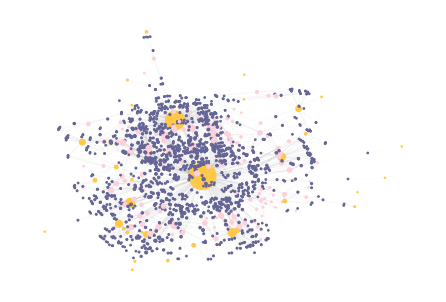

In [102]:
mov_scene = {}

for num, name in enumerate(tripod['movie_name']):
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene

        
    
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    count = 0
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        for char, (embs,sent) in contents.items():        
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.60 and score< 0.99:
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    type_color = {'scene':'#FFCFDA','act':'#646496','char':'#FFC846'}
    type_size = {'scene':15,'act':2,'char':40}
    colors = [type_color[g.nodes[node]["label"]] for node in list(g.nodes())]
    sizes = [type_size[g.nodes[node]["label"]] for node in list(g.nodes())]
    d = nx.degree(g)
    d = [(d[node]+1) for node in g.nodes()]
    nx.nx_agraph.write_dot(g,'test.dot')
    #pos=graphviz_layout(g, prog='dot')
    #pos = nx.circular_layout(g)
    nx.draw(g,node_color= colors,with_labels=False, node_size=d,width=0.01,alpha=1)
    #plt.figure(figsize=(0.5,1))
    #plt.show(block=False)
    plt.savefig("The Back-up Plan_graph.png",dpi=300)
    break

In [81]:
name

'The Back-up Plan'

In [88]:
g.nodes

NodeView(('scene_1', '1_act_1', 'char_ZOE', '1_act_2', '1_act_3', '1_act_4', '1_act_5', '1_act_6', '1_act_7', '1_act_8', '1_act_9', '1_act_10', '1_act_11', 'char_DRHARRIS', '1_act_12', '1_act_13', '1_act_14', '1_act_15', '1_act_16', '1_act_17', 'char_BOBBY', 'scene_2', '2_act_1', '2_act_2', '2_act_3', '2_act_4', '2_act_5', '2_act_6', '2_act_7', '2_act_8', '2_act_9', '2_act_10', '2_act_11', 'scene_3', '3_act_1', '3_act_2', '3_act_3', '3_act_4', '3_act_5', '3_act_6', '3_act_7', '3_act_8', '3_act_9', '3_act_10', '3_act_11', 'char_MONA', 'scene_4', '4_act_1', '4_act_2', '4_act_3', '4_act_4', '4_act_5', '4_act_6', '4_act_7', '4_act_8', '4_act_9', '4_act_10', '4_act_11', '4_act_12', '4_act_13', '4_act_14', '4_act_15', '4_act_16', '4_act_17', '4_act_18', 'scene_5', '5_act_1', '5_act_2', '5_act_3', 'scene_6', '6_act_1', '6_act_2', '6_act_3', '6_act_4', '6_act_5', 'scene_7', '7_act_1', '7_act_2', '7_act_3', 'char_PREGNANTWOMEN', 'scene_8', '8_act_1', '8_act_2', '8_act_3', '8_act_4', '8_act_5', 

In [ ]:
Juno (film)

In [28]:
mov_scene = {}

for num, name in enumerate(tripod['movie_name']):
    if name !='Juno (film)':
        continue
    name = "10 Things I Hate About You"
    mov = Movie('Segmented_screenplays/'+name+'_script_segmented.txt')
    scene_embedding = {}
    total_embedding = []
    total_sentence = []
    
    for i, char_dict in mov.scene_dict.items():
        scene = {}
        for char, sent in char_dict.items():
            emb = make_embedding(sent)
            scene[char] = [emb,sent]       
            total_embedding += emb
            total_sentence +=sent
        scene_embedding[i] = scene

        
    
    emb_act = []
    g_list = []
    id_num = 1
    node_embedding = {}
    total_act = []
    count = 0
    for i, (scene, contents) in enumerate(scene_embedding.items()):
        #line = 'scene_' + str(scene) + '  ' + 'scene_' + str(scene+1) + '  ' + '1' + '  ' + str(id_num)
        #if i != len(scene_embedding_reduction.items())-1:
        #    g_list.append([line])
        #id_num +=1 
        sent_num = 1
        sentnum_emb = {}
        sentnum_sent = {}
        for char, (embs,sent) in contents.items():        
            for emb,s in zip(embs,sent):
                sentnum_emb[sent_num] = emb
                sentnum_sent[sent_num] = s
                line = 'scene_' + str(scene) + '  ' + str(scene) + '_act_' + str(sent_num) + '  ' + '2' + '  ' + str(id_num)
                total_act.append(str(scene) + '_act_' + str(sent_num))
                node_embedding[str(scene) + '_act_' + str(sent_num)] = emb
                id_num += 1
                g_list.append([line])
                line = str(scene) + '_act_' + str(sent_num) + '  ' + 'char_' + char + '  ' + '3' + '  ' + str(id_num)
                id_num += 1
                sent_num += 1
                g_list.append([line])
        if sent_num!=1:     
            for j in range(1,sent_num):
                for k in range(j+1,sent_num):
                    if len(sentnum_sent[j])>25 and len(sentnum_sent[k])>25:
                        score = util.cos_sim(sentnum_emb[j],sentnum_emb[k])[0]
                        if score > 0.60 and score< 0.99:
                            print(sentnum_sent[j], '|||',sentnum_sent[k],'\n',score)
                            print('============================')
                            line = str(scene) + '_act_' + str(j) + '  ' + str(scene) + '_act_' + str(k) + '  ' + '4' + '  ' + str(id_num)
                            id_num += 1
                            g_list.append([line])

            
            
    with open('test.csv', 'w',newline='') as f: 
        write = csv.writer(f)    
        write.writerows(g_list)
    g= read_graph('test.csv')
    attr = {}
    for node in g.nodes():
        if 'scene' in node:
            attr[node]='scene'
        elif 'act' in node:
            attr[node]='act'
        elif 'char' in node:
            attr[node]='char'
    nx.set_node_attributes(g, attr,"label")
    stellar_g = StellarGraph.from_networkx(g)
    stellar_g.info()
    
       # Create the random walker
    rw = UniformRandomMetaPathWalk(stellar_g)

    walks1 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=1,  # number of random walks per root node
        metapaths=metapaths,  # the metapaths
    )

    walks2 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length*2,  # maximum length of a random walk
        n=60,  # number of random walks per root node
        metapaths=metapaths2,  # the metapaths
    )
    
    walks3 = rw.run(
        nodes=list(stellar_g.nodes()),  # root nodes
        length=walk_length,  # maximum length of a random walk
        n=5,  # number of random walks per root node
        metapaths=metapaths3,  # the metapaths
    )


    walks = []
    for w in walks1:
        if len(w)>1:
            walks.append(w)
    for w in walks2:
        if len(w)>1:
            walks.append(w)
    for w in walks3:
        if len(w)>1:
            walks.append(w)

    print("Number of random walks: {}".format(len(walks))) 
    
    w2v = Word2Vec(vector_size=384, window=3, min_count=0, sg=1, workers=4, epochs=0)
    w2v.build_vocab(corpus_iterable=[list(g.nodes())])
    for key in w2v.wv.index_to_key:
        if key in node_embedding.keys():
            w2v.wv[key] = node_embedding[key]
    
    node_ids = [i for i in w2v.wv.index_to_key if 'scene' in i]
    node_ids.sort()
    node_ids.sort(key=len)
    random.shuffle(walks)
    
    w2v.train(walks, total_examples=w2v.corpus_count, epochs=60)
    # Retrieve node embeddings and corresponding subjects
    w2v.save('word2vec_tripod_extra+emb/'+ name + 'word2vec.model')
    mov_scene[name] = node_ids
    break

BIANCA STRATFORD, a beautiful sophomore, stands facing the mirror, applying lipstick. ||| Bianca is immediately greeted by an admiring crowd, both boys and girls alike. 
 tensor([0.7298])
BIANCA STRATFORD, a beautiful sophomore, stands facing the mirror, applying lipstick. |||   Bianca smiles proudly, acknowledging her fans. 
 tensor([0.7276])
Bianca is immediately greeted by an admiring crowd, both boys and girls alike. |||   Bianca smiles proudly, acknowledging her fans. 
 tensor([0.7612])
Bianca is immediately greeted by an admiring crowd, both boys and girls alike. |||   Her less extraordinary, but still cute friend, CHASTITY stands next to her. 
 tensor([0.6141])
  Bianca smiles proudly, acknowledging her fans. |||   Her less extraordinary, but still cute friend, CHASTITY stands next to her. 
 tensor([0.6057])
  Her less extraordinary, but still cute friend, CHASTITY stands next to her. ||| The greetings continue as Chastity remains wordless and unaddressed by her side. 
 tensor([

 tensor([0.6578])
Okay... then how 'bout we try out some ||| Seems like she could get a date easy enough... 
 tensor([0.6064])
Cameron sits with an empty chair beside him. ||| Cameron smiles, having no idea how stupid he is 
 tensor([0.6308])
Unlikely, but even so, she still can't go out with you.  So what's the point? ||| Did she actually say she'd go out with you? 
 tensor([0.7651])
Unlikely, but even so, she still can't go out with you.  So what's the point? ||| You know, if you do go out with Bianca, you'd be set.  You'd outrank everyone. 
 tensor([0.6261])
You wanna go out with him? ||| Did she actually say she'd go out with you? 
 tensor([0.6162])
What makes you think he'll do it? ||| Forget his reputation.  Do you think we've got a plan or not? 
 tensor([0.6196])
No kidding.  He's a criminal.  I heard he lit a state trooper on fire.  He just got out of Alcatraz... ||| I'm serious, man, he's whacked.  He sold his own liver on the black market so he could buy new speakers. 
 tenso

Mandella and Kat glow with sweat. ||| NEAR THE STAGE Kat looks at Mandella. 
 tensor([0.7462])
The crowd files out of the club, Kat and Mandella amongst them. ||| Kat pokes her, then looks back at the club dreamily. 
 tensor([0.6588])
The crowd files out of the club, Kat and Mandella amongst them. ||| Kat links her arm through Mandella's and they head for the car. 
 tensor([0.6908])
The crowd files out of the club, Kat and Mandella amongst them. |||   A^ they're walking toward the parking lot, Patrick coasts by in his truck. 
 tensor([0.6509])
Mandella watches Kat as she stares after Patrick ||| Kat glances sharply at her. 
 tensor([0.6672])
Mandella watches Kat as she stares after Patrick ||| Kat pokes her, then looks back at the club dreamily. 
 tensor([0.6595])
Mandella watches Kat as she stares after Patrick ||| Kat links her arm through Mandella's and they head for the car. 
 tensor([0.6874])
The crowd files out of the club, Kat and Mandella amongst them. ||| Kat pokes her, then l

 tensor([0.6304])
Cameron grins and drives away ||| Bianca and Cameron ride in silence. 
 tensor([0.6304])
Kat, my lady, you sway to the rhythm of my heart. ||| Kat, babe, you were on fire. 
 tensor([0.7079])
Kat, my lady, you sway to the rhythm of my heart. ||| Kat sits at her desk, burying her face in a book as the others enter. 
 tensor([0.6247])
Because the deputy meant him no harm, my friend.  It was only the sheriff that was the oppressor. ||| Okay, now tell me again why he didn't shoot the deputy? 
 tensor([0.7181])
Yippe kai-aye, bra. (to Kat) ||| Kat, babe, you were on fire. 
 tensor([0.6351])
Kat, babe, you were on fire. ||| Kat sits at her desk, burying her face in a book as the others enter. 
 tensor([0.6409])
Kat, babe, you were on fire. |||   Kat looks up, down and around, everywhere but at Patrick. 
 tensor([0.6721])
Kat, babe, you were on fire. |||   Kat looks up, down and around, everywhere but at Patrick. 
 tensor([0.6721])
Joey saunters in and takes his seat. ||| Kat

 tensor([0.7484])
Kat steps forward, looking around and spots Cameron and ||| Patrick looks toward the door and taps Kat. 
 tensor([0.7018])
Kat steps forward, looking around and spots Cameron and |||   Patrick and Kat enter, Kat attempting to deny the romance of it. 
 tensor([0.6799])
Kat steps forward, looking around and spots Cameron and ||| Patrick looks toward the door and taps Kat. 
 tensor([0.7018])
  She spots Kat and hurries over. ||| Patrick looks toward the door and taps Kat. 
 tensor([0.6749])
  She spots Kat and hurries over. |||   Patrick and Kat enter, Kat attempting to deny the romance of it. 
 tensor([0.6314])
  She spots Kat and hurries over. ||| Patrick looks toward the door and taps Kat. 
 tensor([0.6749])
  She spots Kat and hurries over. |||   She turns and points Mandella the same way. 
 tensor([0.6360])
  She spots Kat and hurries over. ||| Kat steps forward, looking around and spots Cameron and 
 tensor([0.7484])
Patrick looks toward the door and taps Kat. ||| 

Number of random walks: 6086


NameError: name 'Word2Vec' is not defined